In [9]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

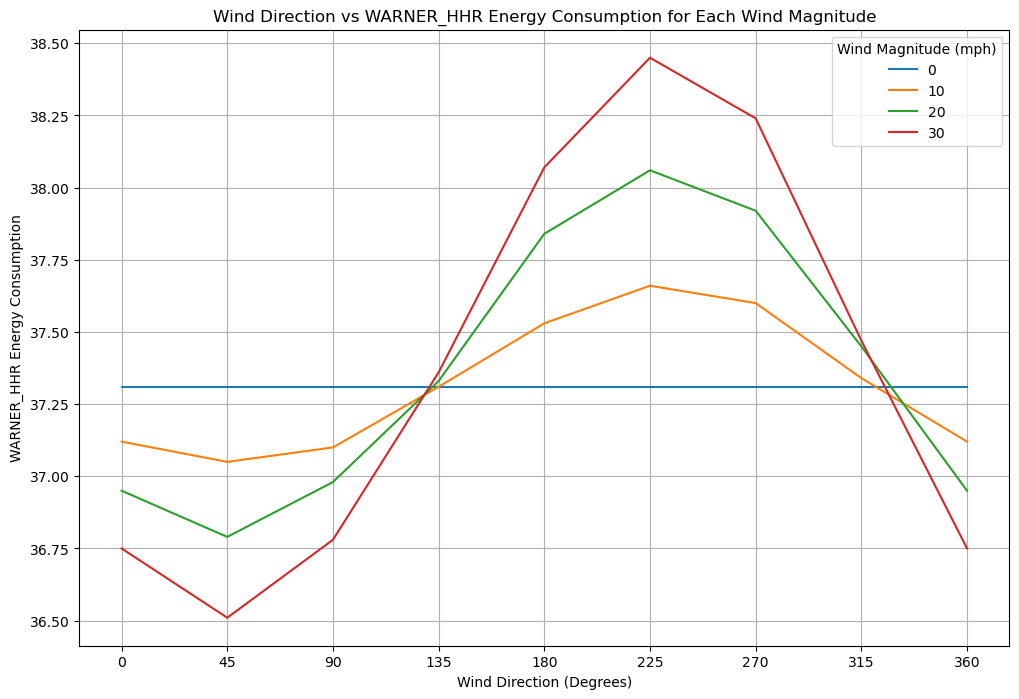

In [22]:
# Reconnect to the SQLite database
conn = sqlite3.connect('eVTOL-energy-consumption/flight_data.db')

# Query to select the relevant columns for WARNER_HHR
query = """
SELECT WARNER_HHR_energy_consumption, wind_direction_degrees, wind_magnitude_mph
FROM flight_metrics
"""

# Loading the data into a pandas DataFrame for WARNER_HHR
df_warn_hhr = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Plotting for WARNER_HHR
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_warn_hhr, x='wind_direction_degrees', y='WARNER_HHR_energy_consumption', hue='wind_magnitude_mph', palette='tab10')
plt.title('Wind Direction vs WARNER_HHR Energy Consumption for Each Wind Magnitude')
plt.xlabel('Wind Direction (Degrees)')
plt.ylabel('WARNER_HHR Energy Consumption')
plt.xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
plt.legend(title='Wind Magnitude (mph)')
plt.grid(True)
plt.show()


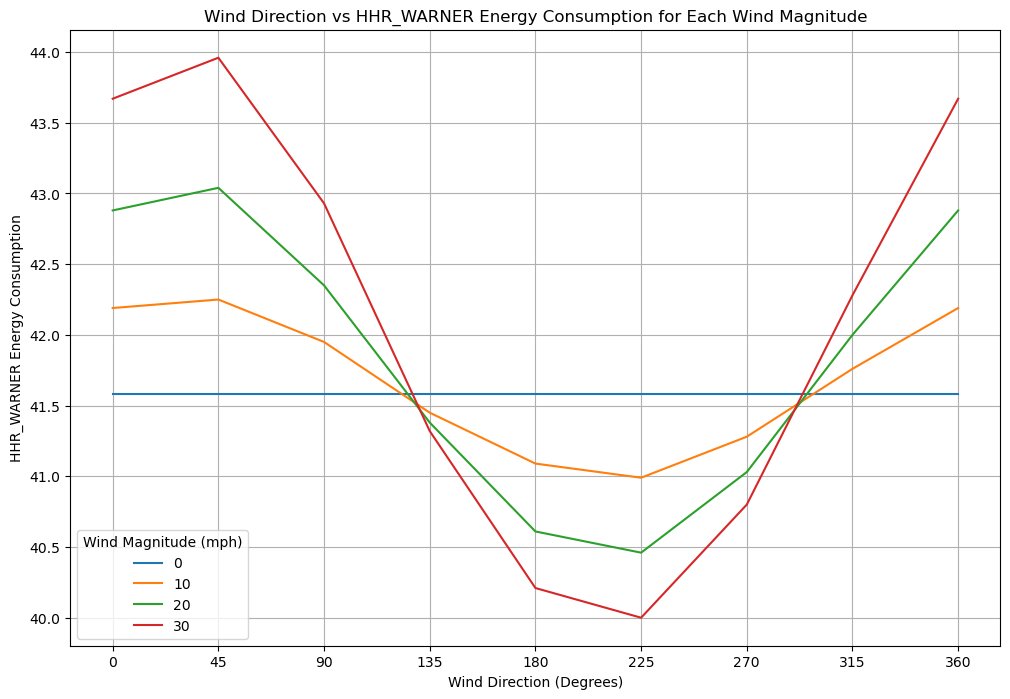

In [23]:
# Reconnect to the SQLite database
conn = sqlite3.connect('eVTOL-energy-consumption/flight_data.db')

# Query to select the relevant columns for WARNER_HHR
query = """
SELECT HHR_WARNER_energy_consumption, wind_direction_degrees, wind_magnitude_mph
FROM flight_metrics
"""

# Loading the data into a pandas DataFrame for WARNER_HHR
df_warn_hhr = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Plotting for WARNER_HHR
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_warn_hhr, x='wind_direction_degrees', y='HHR_WARNER_energy_consumption', hue='wind_magnitude_mph', palette='tab10')
plt.title('Wind Direction vs HHR_WARNER Energy Consumption for Each Wind Magnitude')
plt.xlabel('Wind Direction (Degrees)')
plt.xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
plt.ylabel('HHR_WARNER Energy Consumption')
plt.legend(title='Wind Magnitude (mph)')
plt.grid(True)
plt.show()


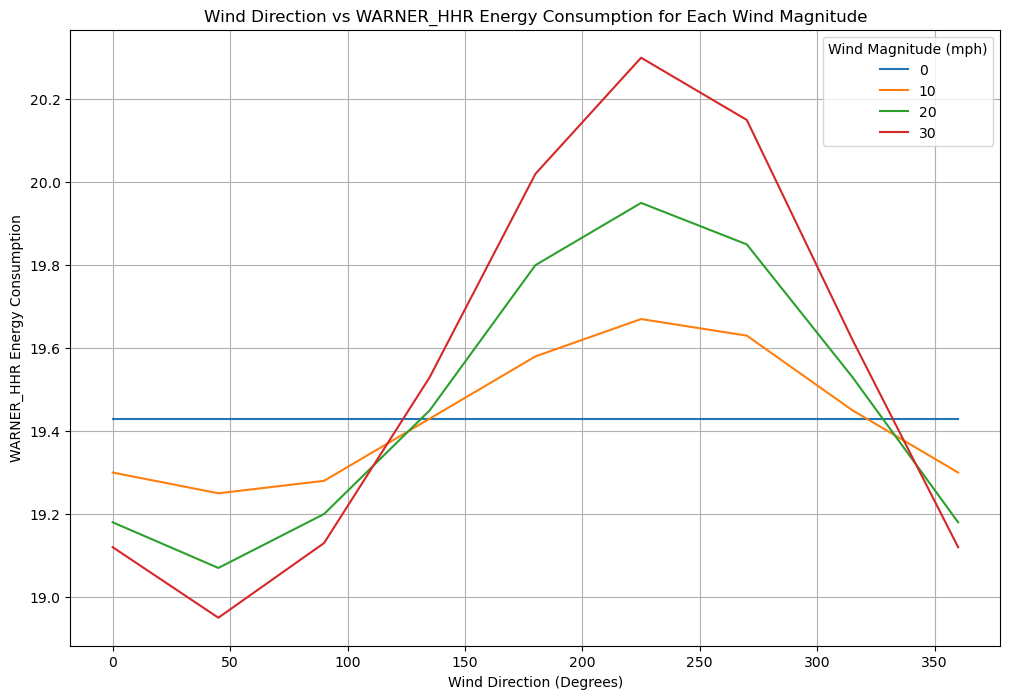

In [21]:
# Reconnect to the SQLite database
conn = sqlite3.connect('eVTOL-energy-consumption/flight_data.db')

# Query to select the relevant columns for WARNER_HHR
query = """
SELECT WARNER_HHR_flight_time, wind_direction_degrees, wind_magnitude_mph
FROM flight_metrics
"""

# Loading the data into a pandas DataFrame for WARNER_HHR
df_warn_hhr = pd.read_sql_query(query, conn)
df_warn_hhr['WARNER_HHR_flight_time'] = round(df_warn_hhr['WARNER_HHR_flight_time']/60,2)

# Close the database connection
conn.close()

# Plotting for WARNER_HHR
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_warn_hhr, x='wind_direction_degrees', y='WARNER_HHR_flight_time', hue='wind_magnitude_mph', palette='tab10')
plt.title('Wind Direction vs WARNER_HHR Energy Consumption for Each Wind Magnitude')
plt.xlabel('Wind Direction (Degrees)')
plt.ylabel('WARNER_HHR Energy Consumption')
plt.legend(title='Wind Magnitude (mph)')
plt.grid(True)
plt.show()


In [13]:
# It appears that the code execution environment has been reset, and the previous data is lost.
# Re-importing the necessary libraries and re-loading the data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset again
file_path = 'data/output_route.csv'
data = pd.read_csv(file_path)

# Remove rows with NaN values
data_cleaned = data.dropna()

# Summing energy consumption values for each flight phase for each flight direction
grouped_data = data_cleaned.groupby(['flight_direction', 'phase'])['energy_consumption'].sum().reset_index()

# Display the grouped data to verify before plotting
grouped_data.head()


,flight_direction,phase,energy_consumption
0,HHR_WARNER,CLIMB,14.57
1,HHR_WARNER,CLIMB TRANSITION,2.51
2,HHR_WARNER,CRUISE,9.93
3,HHR_WARNER,DESCENT,3.92
4,HHR_WARNER,DESCENT TRANSITION,1.89


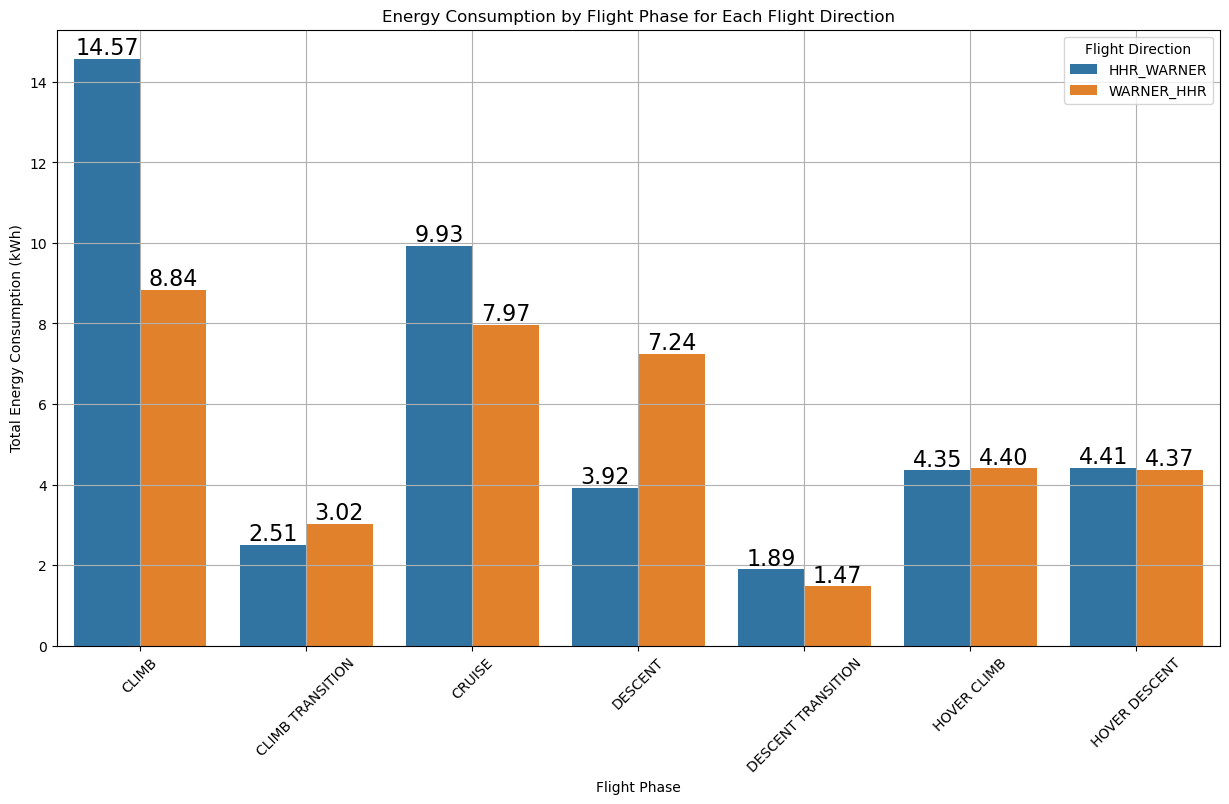

In [18]:
# Plotting all flight directions in the same bar plot with a legend to identify them
plt.figure(figsize=(15, 8))
sns.barplot(x='phase', y='energy_consumption', hue='flight_direction', data=grouped_data, palette='tab10')

# Adding values on top of the bars
for bar in plt.gca().patches:
    plt.gca().annotate(format(bar.get_height(), '.2f'), 
                       (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                       ha='center', va='center', 
                       size=16, xytext=(0, 8), 
                       textcoords='offset points')

plt.title('Energy Consumption by Flight Phase for Each Flight Direction')
plt.xlabel('Flight Phase')
plt.ylabel('Total Energy Consumption (kWh)')
plt.legend(title='Flight Direction')
plt.xticks(rotation=45)
plt.grid()
plt.show()
